<a href="https://colab.research.google.com/github/GiX7000/time-series-alignment-with-DTW/blob/main/dtw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Similarity with Dynamic Time Warping algorithm.

In this notebook, we are going to implement the algorithm Dynamic Time Warpping (DTW) in order to compute the similarities between time series of different time resolutions. We first load, explore and preprocess the given dataset, then we apply the algorithm and finally we present its results.

In [ ]:
# useful libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Load, explore and preprocess the given dataset.

In [ ]:
# load the dataset
dataset = pd.read_csv("/content/dtw_test.csv")

# print the first few rows of the dataset
print(dataset.head())

   id                                           series_a  \
0   0  [75.125, 75.32, 75.06, 74.88, 74.92, 74.83, 75...   
1   1  [26.0, 25.995, 25.8307, 25.85, 26.0, 26.0, 26....   
2   2  [60.23, 60.1, 59.8589, 60.01, 60.19, 60.08, 60...   
3   3  [28.4, 28.65, 28.75, 28.65, 28.7099, 28.8, 28....   
4   4  [4.98, 4.95, 4.88, 4.91, 4.93, 4.9, 4.9, 4.9, ...   

                                            series_b  
0  [75.125, 75.32, 74.88, 74.92, 74.83, 75.0, 74....  
1  [26.0, 25.8307, 26.0, 26.0, 26.0, 26.1471, 26....  
2  [59.8589, 60.19, 60.4, 60.59, 60.27, 60.23, 60...  
3  [28.4, 28.65, 28.7099, 29.0, 29.0651, 28.8, 28...  
4  [4.91, 4.93, 4.9, 4.9, 4.9132, 4.9344, 4.9155,...  


In [ ]:
# explore the dataset
print(dataset.info())

# let's print some info
print(f"\nMissing Values:\n {dataset.isnull().sum()}")
print(f"\nUnique Values:\n {dataset.nunique()}")
print(f"\nDuplicate Rows: {dataset.duplicated().sum()}")
print(f"Shape of dataset: {dataset.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1002 non-null   int64 
 1   series_a  1002 non-null   object
 2   series_b  1002 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
None

Missing Values:
 id          0
series_a    0
series_b    0
dtype: int64

Unique Values:
 id          1002
series_a    1002
series_b    1002
dtype: int64

Duplicate Rows: 0
Shape of dataset: (1002, 3)


Our dataset contains $1001$ rows, where each row represents a pair of time series stored in the columns ```series_a``` and ```series_b```. These columns consist of comma-separated strings that encode the numerical values of the time series. Each row corresponds to a unique sample, and the time series in series_a and series_b and can have different length from those in other samples.

To enable numerical calculations, it is necessary to convert the series_a and series_b columns into numerical arrays. This transformation ensures that we can process the data using mathematical operations and algorithms, such as Dynamic Time Warping (DTW), which calculates the similarity between time series by aligning their points. Without this conversion, the raw string format would not allow for meaningful numerical comparisons or distance calculations.

Scaling is equally important because time series in series_a and series_b may differ significantly in their ranges or magnitudes. For example, one time series may range from $0.7$ to $1$, while another spans $70$ to $77$. Without scaling, these differences could bias the DTW results, giving emphasis on magnitude over patterns or trends in the series. By scaling the data (e.g., using min-max normalization), we ensure that all time series are comparable on the same scale, enabling fair and accurate similarity comparisons.

In [ ]:
# function to convert sequences from strings to numpy arrays
def preprocess_sequence(sequence):
  """ Converts a comma-separated string to a NumPy array of floats. """
  sequence = sequence.strip('[]') ## remove brackets from processing
  return np.array([float(x) for x in sequence.split(',') if x.strip()]) # split the string by commas, remove empty elements and convert str to float

# min-max scaling function
def min_max_scale(sequence):
  """ Scales a sequence to the range [0, 1] using min-max scaling. """
  min_val = np.min(sequence)
  max_val = np.max(sequence)
  if max_val == min_val: # case in which all elements are the same (fixed after warning)
    return np.zeros_like(sequence) # return zero array of the same shape
  return (sequence - min_val) / (max_val - min_val)

In [ ]:
# apply the preprocessing function
dataset['array_a'] = dataset['series_a'].apply(preprocess_sequence)
dataset['array_b'] = dataset['series_b'].apply(preprocess_sequence)

# apply min-max scaling function
dataset['array_a'] = dataset['array_a'].apply(min_max_scale)
dataset['array_b'] = dataset['array_b'].apply(min_max_scale)

# print top lines of array_a and array_b
dataset[['array_a', 'array_b']].head()

,array_a,array_b
0,"[0.15777439024390186, 0.18749999999999836, 0.1...","[0.15777439024390186, 0.18749999999999836, 0.1..."
1,"[0.2, 0.1990000000000002, 0.16614000000000004,...","[0.1612903225806452, 0.12488172043010762, 0.16..."
2,"[0.13649025069637755, 0.10027855153203337, 0.0...","[0.03321229050279232, 0.12569832402234524, 0.1..."
3,"[0.018181818181817886, 0.04415584415584386, 0....","[0.018181818181817886, 0.04415584415584386, 0...."
4,"[0.12840466926070046, 0.11673151750972759, 0.0...","[0.10156249999999993, 0.10937499999999976, 0.0..."


Let's see now how the distsributions of lengths of the sequences are.

In [ ]:
# calculate the lengths of sequences and get some statistical information about the lengths of the series
dataset['len_array_a'] = dataset['array_a'].apply(len)
dataset['len_array_b'] = dataset['array_b'].apply(len)
dataset[['len_array_a', 'len_array_b']].describe()

,len_array_a,len_array_b
count,1002.000000,1002.000000
mean,921.941118,645.337325
std,197.284081,138.083022
min,1.000000,1.000000
25%,962.000000,673.000000
50%,979.000000,685.000000
75%,987.000000,691.000000
max,998.000000,699.000000


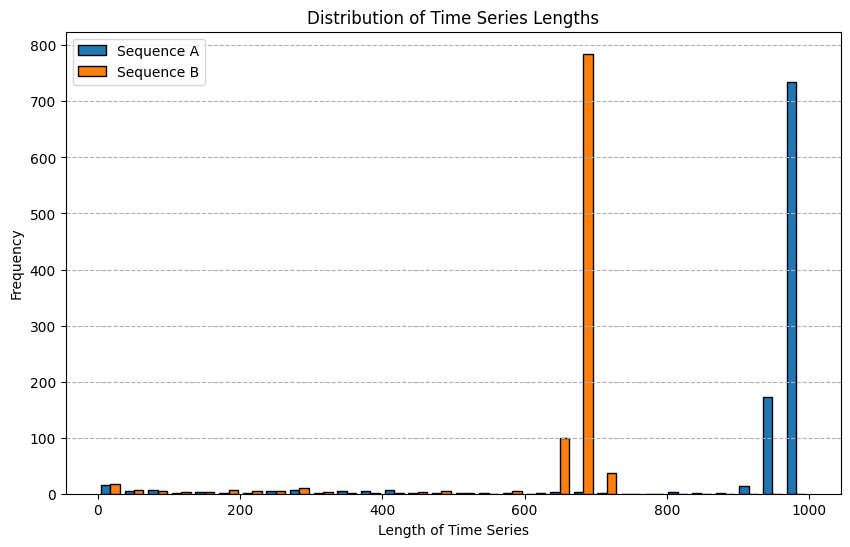

In [ ]:
# plot the distribution of lengths
data = [dataset['len_array_a'], dataset['len_array_b']]
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, label=['Sequence A', 'Sequence B'], edgecolor='black')
plt.title('Distribution of Time Series Lengths')
plt.xlabel('Length of Time Series')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

Let's also see how two pairs of sequences look like.

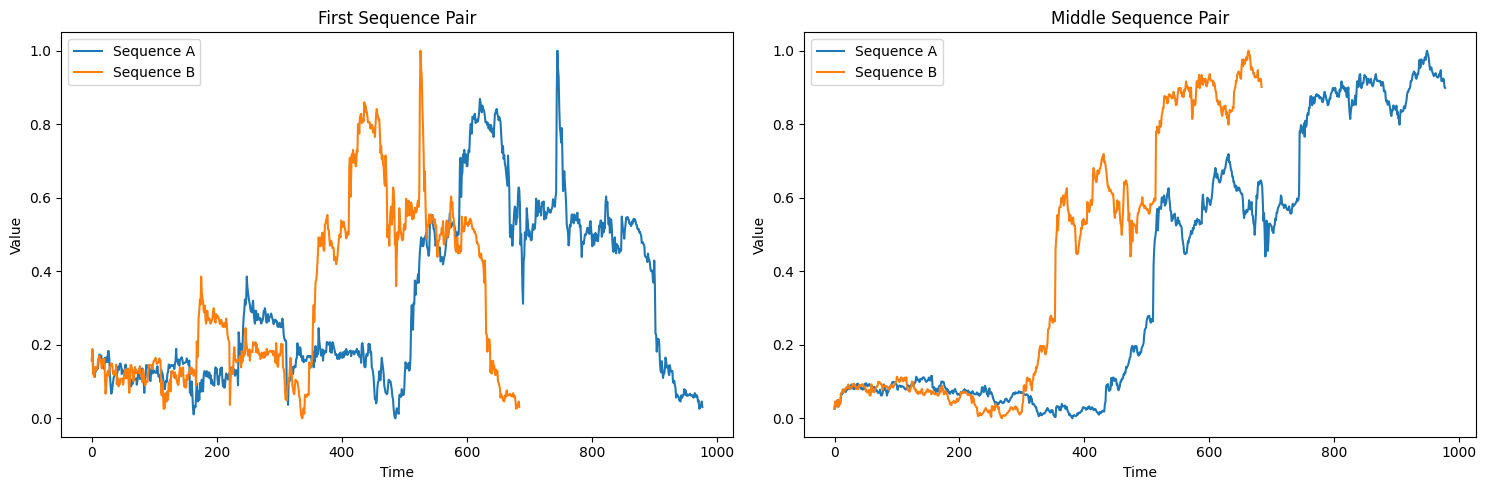

In [ ]:
# plotting first sequence pair
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(dataset['array_a'].iloc[0], label='Sequence A')
ax1.plot(dataset['array_b'].iloc[0], label='Sequence B')
ax1.set_title('First Sequence Pair')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend(loc='upper left')

# plotting a middle sequence pair
ax2.plot(dataset['array_a'].iloc[500], label='Sequence A')
ax2.plot(dataset['array_b'].iloc[500], label='Sequence B')
ax2.set_title('Middle Sequence Pair')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# final dataset ready for DTW
dtw_dataset = dataset[['id', 'array_a', 'array_b']]
print("\nPreprocessing complete. Ready for DTW!")
print(dtw_dataset.head())
print(" ")
print(dtw_dataset.info())

print(f"\nDataset Columns: {dtw_dataset.columns}")
print(f"Dataset shape: {dtw_dataset.shape}")


Preprocessing complete. Ready for DTW!
   id                                            array_a  \
0   0  [0.15777439024390186, 0.18749999999999836, 0.1...   
1   1  [0.2, 0.1990000000000002, 0.16614000000000004,...   
2   2  [0.13649025069637755, 0.10027855153203337, 0.0...   
3   3  [0.018181818181817886, 0.04415584415584386, 0....   
4   4  [0.12840466926070046, 0.11673151750972759, 0.0...   

                                             array_b  
0  [0.15777439024390186, 0.18749999999999836, 0.1...  
1  [0.1612903225806452, 0.12488172043010762, 0.16...  
2  [0.03321229050279232, 0.12569832402234524, 0.1...  
3  [0.018181818181817886, 0.04415584415584386, 0....  
4  [0.10156249999999993, 0.10937499999999976, 0.0...  
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1002 non-null   int64 
 1   array_a  1002 non-null   object
 2   array_b 

## 2. Apply Dynamic Time Warping (DTW) algorithm.

Dynamic Time Warping ([DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping)) is an algorithm used to measure similarity between two time series, even if they differ in length or are misaligned. It works by creating a distance matrix where each cell represents the cost (e.g., Euclidean distance) of aligning a point in one series with a point in the other. DTW then finds the optimal alignment path through the matrix by minimizing the cumulative cost of alignments, allowing for insertions, deletions, or matches.

DTW algorithm:


*   Let $x = [x_1, x_2, ..., x_n]$ and $y = [y_1, y_2, ..., y_m]$ be two sequences of length $n$ and $m$, respectively as inputs.

*   Define DTW cost matrix $D(i, j)$, where $i$ and $j$ correspond to the indices of the sequences $x$ and $y$ and is of shape $(n + 1, m + 1)$.

*   Initialization:

    for $i = 1$ to $n$: $D_{i,0} = \infty$

    for $j = 1$ to $m$: $D_{0,j} = \infty$

*   Calculate the cost matrix $D$:

  $\text{D}(i,j) = d(x_i, y_j) + \min \begin{cases}
    \text{D}(i-1, j-1) & \text{(match)} \\
    \text{D}(i-1, j) & \text{(insertion)} \\
    \text{D}(i, j-1) & \text{(deletion)}     
\end{cases}$

  $\forall i \in \{1, 2, \dots, n\}, \ \forall j \in \{1, 2, \dots, m\}$, where

  $d(x_i, y_j) = \sqrt{\sum_{k=1}^{n} (x_{ik} - y_{jk})^2}$ is the euclidean distance(cost) of aligning the sequences $x_i$ and $y_j$ and

  $D(i, j)$is the cumulative cost of aligning the sequences up to $x_i$ and $y_j$.



*   Get alignment (Backtracking):

  Once the matrix $D(i, j)$ is computed, backtracking is used to find the alignment path by tracing from $D(n, m)$ to $D(0, 0)$, selecting the minimum-cost direction (insertion, deletion, or match) at each step, while the overall cost of optimally aligning the two sequences is $D(n, m)$. The value of $D(n, m)$ is calculated by considering all possible alignment paths and selecting the one with the minimum cost. If it is small, the sequences are similar under the alignment and if it is large the sequences differ significantly, even after optimal warping.

In [ ]:
# helper functions
def euclidean_distance(a, b):
  """ Calculates the Euclidean distance between two points. """
  return np.sqrt((a - b) ** 2)

def dtw(seq_a, seq_b):
  """ Computes the DTW distance between two sequences and finds the minimum cost path of DTW matrix. """

  # retrieve sequence lengths
  n, m = len(seq_a), len(seq_b)

  # initialize dtw matrix
  dtw_matrix = np.zeros((n + 1, m + 1)) # dtw_matrix[0, 0] = 0
  dtw_matrix[1:, 0] = np.inf
  dtw_matrix[0, 1:] = np.inf

  # initialize path matrix
  path_matrix = np.zeros((n, m)) # directly stores the direction of movement

  # fill the dtw matrix while keep traceback info
  for i in range(1, n + 1):
    for j in range(1, m + 1):
      cost = euclidean_distance(seq_a[i - 1], seq_b[j - 1])

      # calculate match, insertion and deletion costs (3 possible directions)
      match_cost = dtw_matrix[i - 1, j - 1] # diagonal move (0) : seq_a and seq_b are aligned without gaps
      insertion_cost = dtw_matrix[i - 1, j] # move (1) : an element of seq_b is aligned with a gap in seq_a
      deletion_cost = dtw_matrix[i, j - 1] # leftward move (2) : an element of seq_a is aligned with a gap in seq_b

      # determine the minimum cost and its direction
      D = [match_cost, insertion_cost, deletion_cost ]
      min_index = np.argmin(D) # takes the index where the min is (0, 1, 2)

      # update the DTW matrix and the path matrix
      dtw_matrix[i, j] = cost + D[min_index]
      path_matrix[i - 1, j - 1] = min_index # is comprised of 0, 1, 2 (one for each direction)

  # traceback from bottom right
  i, j = n - 1, m - 1
  path = [(i, j)]
  while i > 0 or j > 0:
    direction = path_matrix[i, j]
    if direction == 0: # match
      i = i - 1
      j = j - 1
    elif direction == 1: # insertion
      i = i - 1
    elif direction == 2: # deletion
      j = j - 1
    path.insert(0, (i, j)) # add the current step to the path

  # remove infinity row and column before returning
  dtw_matrix = dtw_matrix[1:, 1:]

  # calculate and print the overall cost at D(n, m) for the current pair
  overall_cost = dtw_matrix[-1, -1]
  #print(f"Overall DTW cost at D(n, m): {overall_cost:.4f}")

  return dtw_matrix, path, overall_cost # path from bottom right to down left

And now, we are going to apply the Dynamic Time Warping (DTW) algorithm to all instances/sample pairs in the dataset. Since the sequences vary in length, and after having applied magnitude normalization in the preprocess step, we are going now to apply length normalization. Since longer sequences naturally accumulate higher DTW costs, we normalize the costs by dividing them by the combined lengths of the two sequences being compared. This length normalization adjusts the results for sequence size, ensuring a consistent and unbiased comparison across all pairs. By combining these two normalization steps, the DTW distances become standardized, interpretable, and suitable for analyzing alignment costs across the entire dataset.

For lengths normalization, we will use this formula:

$\text{Normalized Cost} = \frac{\text{DTW Cost}}{\text{Length of Time Series 1} + \text{Length of Time Series 2}}$

In [ ]:
# useful initializations
results = [] # storage list for the results
normalized_results = [] # storage list for the normalized results
normalized_min_max_results = [] # storage list for the normalized min-max normalized results
overall_cost = [] # to store overall costs for all pairs
normalized_overall_cost = [] # to store normalized overall costs for all pairs
normalized_min_max_overall_cost = [] # storage list for the normalized min-max normalized results

In [ ]:
# 1. DTW without any normalization
print("Starting DTW ...")
start_time = time.time()
# iterate over each row of the dtw_dataset
for index, row in tqdm(dtw_dataset.iterrows(), total=len(dtw_dataset), desc="Processing DTW pairs"):
  seq_a = row['array_a']
  seq_b = row['array_b']
  seq_length = len(seq_a) + len(seq_b)
  dtw_matrix, path, total_cost = dtw(seq_a, seq_b)
  results.append({'id': row['id'], 'DTW distance': total_cost})
  overall_cost.append(total_cost)

# calculate total computation time
total_time = time.time() - start_time
print(f"\nDTW finished!")
print(f"Total calculation time: {total_time:.2f} seconds")

Starting DTW ...


Processing DTW pairs: 100%|██████████| 1002/1002 [1:15:42<00:00,  4.53s/it]


DTW finished!
Total calculation time: 4542.04 seconds


In [ ]:
# save results to a csv file
results_df = pd.DataFrame(results)
results_df.to_csv("dtw.csv", index=False)
print("Results saved to dtw.csv\n")

Results saved to dtw.csv



In [ ]:
# 2. DTW with normalization based on sequence lengths (for comparing alignments across sequence pairs, identifying which pairs are more aligned regardless of sequence lengths)
print("Starting DTW with normalization ...")
start_time = time.time()
# iterate over each row of the dtw_dataset
for index, row in tqdm(dtw_dataset.iterrows(), total=len(dtw_dataset), desc="Processing DTW pairs"):
  seq_a = row['array_a']
  seq_b = row['array_b']
  seq_length = len(seq_a) + len(seq_b)
  dtw_matrix, path, total_cost = dtw(seq_a, seq_b)
  #results.append({'id': row['id'], 'DTW distance': total_cost})
  overall_cost.append(total_cost)

  # apply normalization
  normalized_cost = total_cost / (seq_length)
  normalized_results.append({'id': row['id'], 'DTW distance': normalized_cost})
  normalized_overall_cost.append(normalized_cost)

# calculate total computation time
total_time = time.time() - start_time
print(f"\nDTW finished!")
print(f"Total calculation time with normalization: {total_time:.2f} seconds")

Starting DTW with normalization ...


Processing DTW pairs: 100%|██████████| 1002/1002 [1:15:16<00:00,  4.51s/it]


DTW finished!
Total calculation time with normalization: 4516.31 seconds


In [ ]:
# save normalized results to a csv file
normalized_results_df = pd.DataFrame(normalized_results)
normalized_results_df.to_csv("normalized_dtw.csv", index=False)
print("Normalized Results based on sequence lengths saved to normalized_dtw.csv\n")

Normalized Results based on sequence lengths saved to normalized_dtw.csv



**Important Note:**
The final results including the normalized DTW distances, are provided in a file named **dtw.csv**.

## 3. Results of DTW algorithm.

Let's make some prints of the above results.

In [ ]:
# display top lines of results
print(results_df.head())

   id  DTW distance
0   0      2.877317
1   1     11.211361
2   2      4.366489
3   3      1.767792
4   4      5.014722


In [ ]:
# display top lines of normalized_results
print(normalized_results_df.head())

   id  DTW distance
0   0      0.001730
1   1      0.006622
2   2      0.002645
3   3      0.001062
4   4      0.002989


Let's make some plots now for a sample pair of our dataset before and after the alignment.

In [ ]:
# plotting functions

def plot_dtw_vizs(row_index, dtw_dataset):
  """ Plots the original sequences and the aligned sequences for a given row index as well as the best path. """

  # retrive the row and time series
  row = dtw_dataset.iloc[row_index]
  series_a = row['array_a']
  series_b = row['array_b']

  # compute DTW distance and path
  dtw_matrix, path, overall_cost = dtw(series_a, series_b)

  # create a figure for vertical layout
  fig = plt.figure(figsize=(16, 8))

  # 1.  original Time Series plot
  plt.subplot(2, 1, 1)
  plt.plot(series_a, label='Series A')
  plt.plot(series_b, label='Series B', linestyle='--')
  plt.title('Original Time Series Before Alignment')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend(loc='upper left')
  plt.grid(True)

  # 2. point to point comparison after DWT alignment plot
  plt.subplot(2, 1, 2)
  plt.plot(series_a, label='Series A', marker='o')
  plt.plot(series_b, label='Series B', marker='x', linestyle='--')
  for i, j in path:
    plt.plot([i, j], [series_a[i], series_b[j]], color='grey', linestyle='--')
  plt.title('Point-to-Point Comparison After DTW Alignment')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend(loc='upper left')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

def best_path_viz(row_index, dtw_dataset):
  """ Plots the original sequences and the best path for a given row index. """

  # retrive the row and time series
  row = dtw_dataset.iloc[row_index]
  series_a = row['array_a']
  series_b = row['array_b']

  # compute DTW distance and path
  dtw_matrix, path, overall_cost = dtw(series_a, series_b)

  # shortest path (best path) plot
  fig = plt.figure(figsize=(24, 8))
  plt.imshow(dtw_matrix, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
  x_path, y_path = zip(*path)
  plt.plot(y_path, x_path, label='Best Path')
  plt.title('Shortest Path (Best Path)')
  plt.xlabel('Series A')
  plt.ylabel('Series B')
  plt.legend(loc='upper left')
  plt.grid(True)
  plt.show()

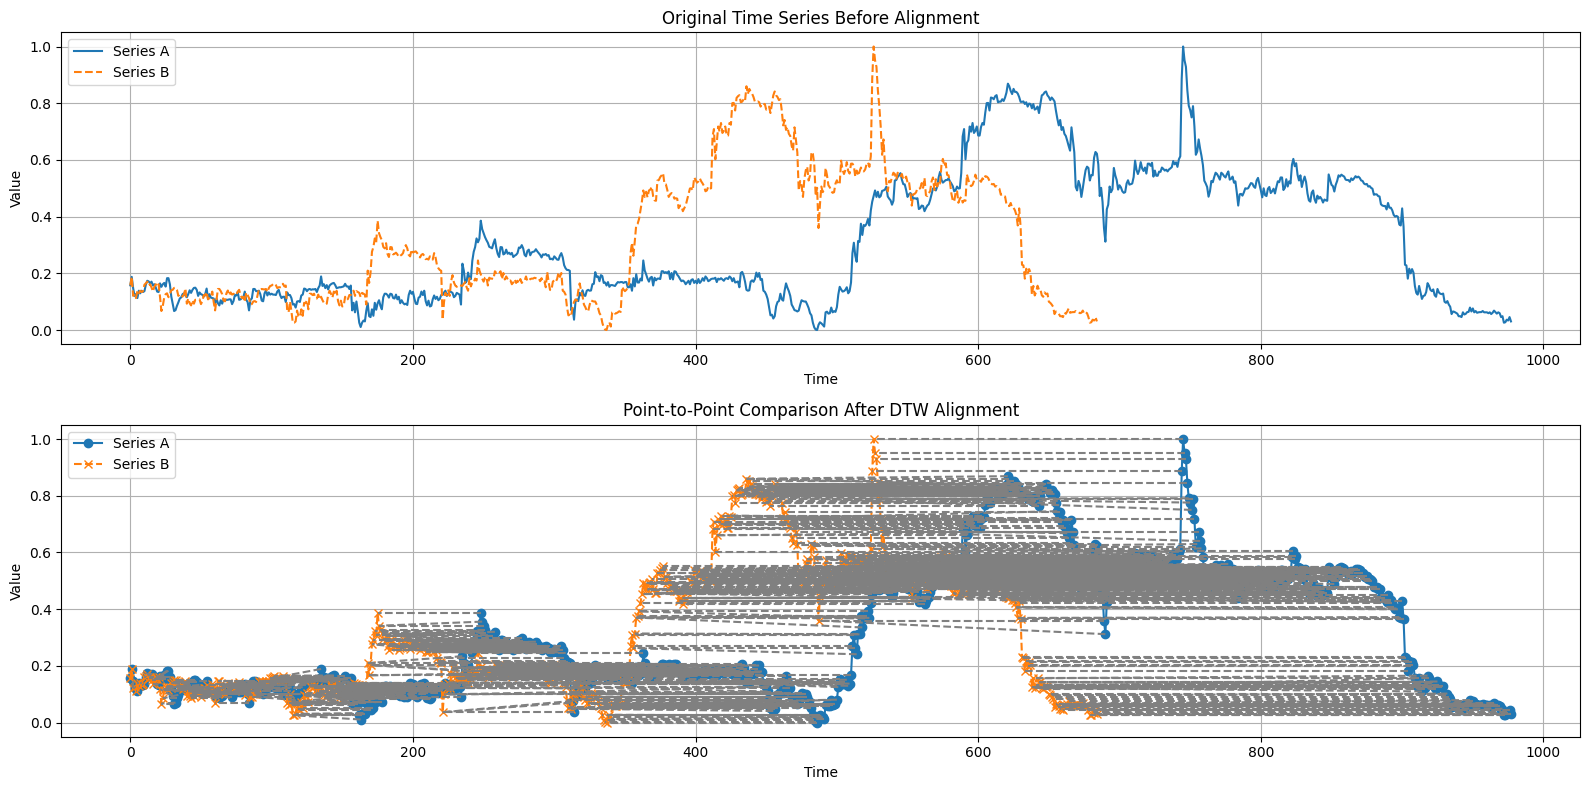

In [ ]:
# alignment for the first pair of sequences
plot_dtw_vizs(0, dtw_dataset)

The top plot of the imagae shows the original time series comparison for Series A and Series B before alignment, while the bottom plot shows us the point-to-point alignment after applying Dynamic Time Warping (DTW), illustrating how the two series are mapped for similarity.

Let's also visualize how their best/short path looks like.

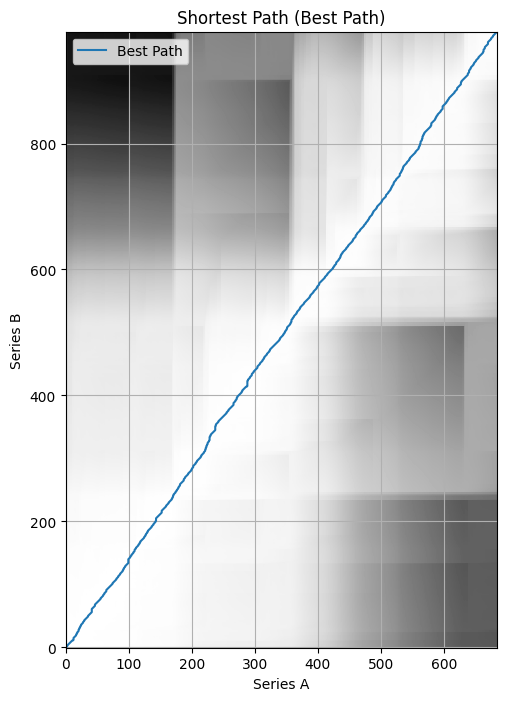

In [ ]:
# best path for the first pair of sequences
best_path_viz(0, dtw_dataset)

The image shows the Dynamic Time Warping (DTW) cost matrix as a grayscale heatmap, where darker areas represent lower alignment costs. The blue line represents the best alignment path between Series A and Series B, indicating the optimal matching points between the two sequences (~minimum cost to perfectly align these time series).